# Implicit Superpixel Regularisation for Impricise Segmentation Labels
This notebook associates the master thesis as part of my Master of Science at the Eindhoven Univerisity of Technology. <br>
Saving models and results got quite messy. Nowadays I would use MLFlow for tracking the experiments. <br>
Jort de Jong

### Import libaries

In [ ]:
import time
import scipy.stats as stats
import random
random.seed(30)
import torch
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
import numpy as np
!pip install segmentation_models_pytorch

In [ ]:
from Functions.utils import *
from Functions.visualization import *
from Functions.model_blocks import *
from Functions.train_eval import *
from Functions.datasets import *

All methods are evaluated with three semantic segmentation datasets. The Cityscapes dataset, the PanNuke dataset and the SUIM dataset. The Cityscapes dataset contains urban street scenes with detailed semantic segmentation labels. The PanNuke dataset contains nuclei instance segmentations across different tissue types. The SUIM dataset contains semantic segmentation labels for underwater images.

### Cityscapes dataset

In [ ]:
city_classes = [('ignore', 255, (0, 0, 0)),
           ('dynamic', 0, (111, 74, 0)),
           ('ground', 1, (81, 0, 81)),
           ('road', 2, (128, 64, 128)),
           ('sidewalk', 3, (244, 35, 232)),
           ('parking', 4, (250, 170, 160)),
           ('rail track', 5, (230, 150, 140)),
           ('building', 6, (70, 70, 70)),
           ('wall', 7, (102, 102, 156)),
           ('fence', 8, (190, 153, 153)),
           ('guard rail', 9, (180, 165, 180)),
           ('bridge', 10, (150, 100, 100)),
           ('tunnel', 11, (150, 120, 90)),
           ('pole', 12, (153, 153, 153)),
           ('polegroup', 13, (153, 153, 153)),
           ('traffic light', 14, (250, 170, 30)),
           ('traffic sign', 15, (220, 220, 0)),
           ('vegetation', 16, (107, 142, 35)),
           ('terrain', 17, (152, 251, 152)),
           ('sky', 18, (70, 130, 180)),
           ('person', 19, (220, 20, 60)),
           ('rider', 20, (255, 0, 0)),
           ('car', 21, (0, 0, 142)),
           ('truck', 22, (0, 0, 70)),
           ('bus', 23, (0, 60, 100)),
           ('caravan', 24, (0, 0, 90)),
           ('trailer', 25, (0, 0, 110)),
           ('train', 26, (0, 80, 100)),
           ('motorcycle', 27, (0, 0, 230)),
           ('bicycle', 28, (119, 11, 32))]

In [ ]:
#Build datasets
train_city = DataSet('Datasets/Cityscapes/Train/Images/', 'Datasets/Cityscapes/Train/Labels/', train=True)
val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Labels/', img_size=(512, 1024))
train_val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Labels/', train=True)
train_val_city = ConcatDataset((train_city, train_val_city))
test_city = DataSet('Datasets/Cityscapes/Test/Images/', 'Datasets/Cityscapes/Test/Labels/', img_size=(512, 1024))

coarse_train_city = DataSet('Datasets/Cityscapes/Train/Images/', 'Datasets/Cityscapes/Train/Coarse_labels/', train=True)
coarse_val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Coarse_labels/', img_size=(512, 1024))
coarse_train_val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Coarse_labels/', train=True)
coarse_train_val_city = ConcatDataset((coarse_train_city, coarse_train_val_city))

In [ ]:
#Build DataLoaders
train_city_loader = DataLoader(train_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
val_city_loader = DataLoader(val_city, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
train_val_city_loader = DataLoader(train_val_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
test_city_loader = DataLoader(test_city, batch_size=18, shuffle=False, num_workers=2, prefetch_factor=9)

coarse_train_city_loader = DataLoader(coarse_train_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=16)
coarse_val_city_loader = DataLoader(coarse_val_city, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
coarse_train_val_city_loader = DataLoader(coarse_train_val_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=16)

### SUIM dataset

In [ ]:
suim_classes = [('ignore', 255, (0, 0, 0)),
                ('HD', 0, (0, 255, 0)),
                ('PF', 1, (0, 0, 255)),
                ('WR', 2, (0, 255, 255)),
                ('RO', 3, (255, 0, 0)),
                ('RI', 4, (255, 0, 255)),
                ('FV', 5, (255, 255, 0)),
                ('SR', 6, (190, 100, 20))]

In [ ]:
#Build datasets
train_suim = DataSet('Datasets/SUIM/Train/Images/', 'Datasets/SUIM/Train/Labels/', train=True)
val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/')
train_val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/', train=True)
train_val_suim = ConcatDataset((train_suim, train_val_suim))
test_suim = DataSet('Datasets/SUIM/Test/Images/', 'Datasets/SUIM/Test/Labels/')

coarse_train_suim = DataSet('Datasets/SUIM/Train/Images/', 'Datasets/SUIM/Train/Labels/', train=True, coarse=True, erode=25, imp=0.005)
coarse_val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/', coarse=True, erode=25, imp=0.005)
coarse_train_val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/', train=True, coarse=True, erode=25, imp=0.005)
coarse_train_val_suim = ConcatDataset((coarse_train_suim, coarse_train_val_suim))

In [ ]:
#Build DataLoaders
train_suim_loader = DataLoader(train_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
val_suim_loader = DataLoader(val_suim, batch_size=22, shuffle=False, num_workers=2, prefetch_factor=11)
train_val_suim_loader = DataLoader(train_val_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
test_suim_loader = DataLoader(test_suim, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)

coarse_train_suim_loader = DataLoader(coarse_train_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
coarse_val_suim_loader = DataLoader(coarse_val_suim, batch_size=22, shuffle=False, num_workers=2, prefetch_factor=11)
coarse_train_val_suim_loader = DataLoader(coarse_train_val_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)

### PanNuke dataset

In [ ]:
pannuke_classes = [('ignore', 255, (0, 0, 0)),
                   ('Neoplastic', 0, (0, 255, 0)),
                   ('Inflammatory', 1, (0, 0, 255)),
                   ('Connective', 2, (0, 255, 255)),
                   ('Dead', 3, (255, 0, 0)),
                   ('Epithelial', 4, (255, 0, 255)),
                   ('Background', 5, (255, 255, 0))]

In [ ]:
#Build datasets
train_pannuke = DataSet('Datasets/PanNuke/Train/Images/', 'Datasets/PanNuke/Train/Labels/', img_size=(256, 256), train=True)
val_pannuke = DataSet('Datasets/PanNuke/Val/Images/', 'Datasets/PanNuke/Val/Labels/', img_size=(256, 256))
train_val_pannuke = DataSet('Datasets/PanNuke/Val/Images/', 'Datasets/PanNuke/Val/Labels/', img_size=(256, 256), train=True)
train_val_pannuke = ConcatDataset((train_pannuke, train_val_pannuke))
test_pannuke = DataSet('Datasets/PanNuke/Test/Images/', 'Datasets/PanNuke/Test/Labels/', img_size=(256, 256))

coarse_train_pannuke = DataSet('Datasets/PanNuke/Train/Images/', 'Datasets/PanNuke/Train/Labels/', img_size=(256, 256), train=True, coarse=True, erode=13, imp=0.005)
coarse_val_pannuke = DataSet('Datasets/PanNuke/Val/Images/', 'Datasets/PanNuke/Val/Labels/', img_size=(256, 256), coarse=True, erode=13, imp=0.005)
coarse_train_val_pannuke = DataSet('Datasets/PanNuke/Val/Images/', 'Datasets/PanNuke/Val/Labels/', img_size=(256, 256), train=True, coarse=True, erode=13, imp=0.005)
coarse_train_val_pannuke = ConcatDataset((coarse_train_pannuke, coarse_train_val_pannuke))

In [ ]:
#Build DataLoaders
train_pannuke_loader = DataLoader(train_pannuke, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
val_pannuke_loader = DataLoader(val_pannuke, batch_size=22, shuffle=False, num_workers=2, prefetch_factor=11)
train_val_pannuke_loader = DataLoader(train_val_pannuke, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
test_pannuke_loader = DataLoader(test_pannuke, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)

coarse_train_pannuke_loader = DataLoader(coarse_train_pannuke, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
coarse_val_pannuke_loader = DataLoader(coarse_val_pannuke, batch_size=22, shuffle=False, num_workers=2, prefetch_factor=11)
coarse_train_val_pannuke_loader = DataLoader(coarse_train_val_pannuke, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)

## Hyperparameter search CityScapes
Finding the optimal hyperparameters for m (superpixel compactness) and lambda (regularization strength).

In [ ]:
m = 0
lmbda = 0.125

encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
loss_function = RegularisedCrossEntropy(lmbda=lmbda, m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, coarse_train_city_loader, coarse_val_city_loader, epochs=50, verbose=False)
save_model(model, loss_function, data_set='cityscapes', label_set='coarse')

#Results
results = eval_model(model, val_city_loader)
save_results(results, model, loss_function, data_set='cityscapes', label_set='coarse', test_set='val')

100%|██████████| 50/50 [52:22<00:00, 62.86s/it]


In [ ]:
m_list = [0, 25, 50, 100]
lmbda_list = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]

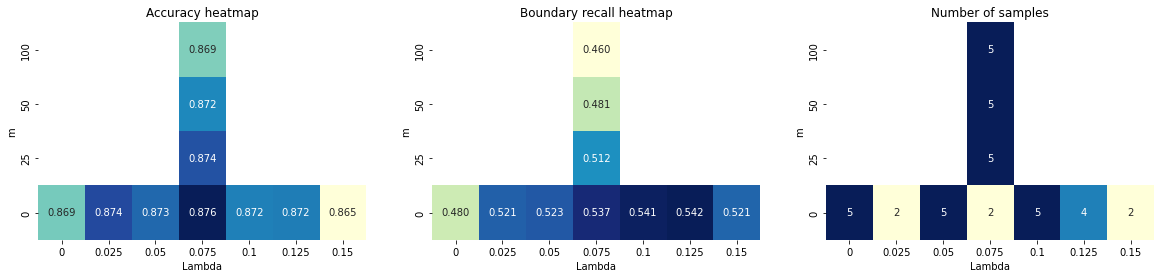

In [ ]:
plot_hyperparameters(lmbda_list, m_list, 'cityscapes', 'val')

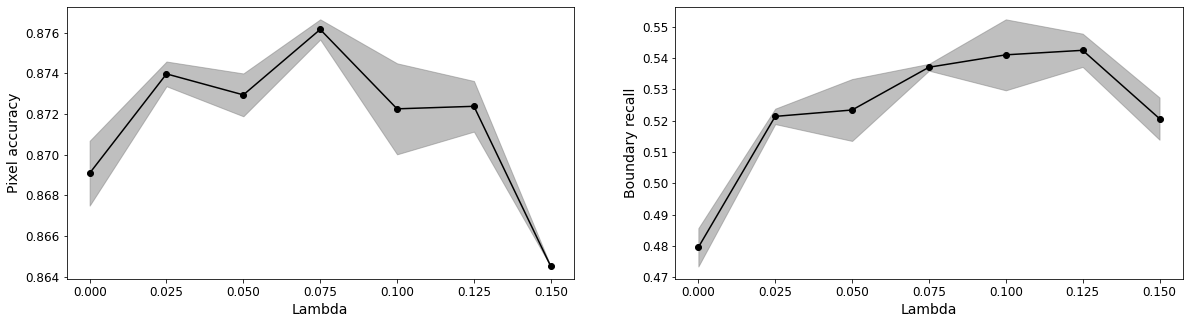

In [ ]:
plot_lmbda(lmbda_list, 0, 'cityscapes', 'val', 'coarse')

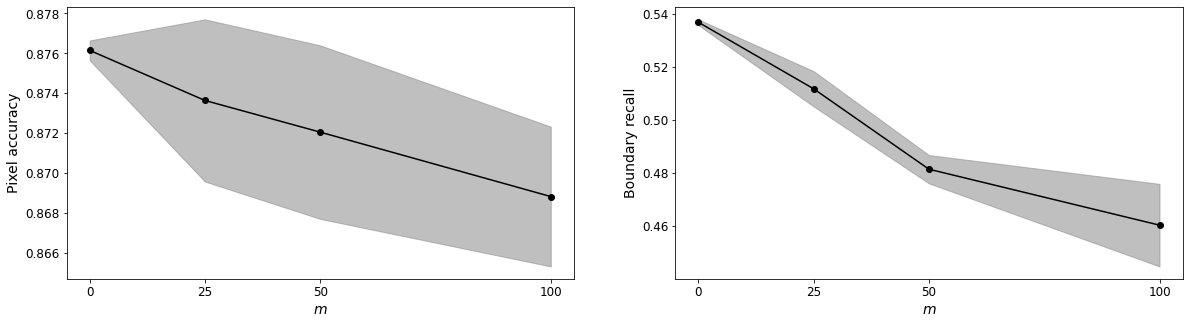

In [ ]:
plot_m(m_list, 0.075, 'cityscapes', 'val', 'coarse')

## Hyperparameter search SUIM
Finding the optimal hyperparameters for m (superpixel compactness) and lambda (regularization strength).

In [ ]:
m = 0
lmbda = 0.15

encoder = ResNet34Encoder()
classifier = FCNHead(256, 7)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
loss_function = RegularisedCrossEntropy(lmbda=lmbda, m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, coarse_train_suim_loader, coarse_val_suim_loader, epochs=75, verbose=False)
save_model(model, loss_function, data_set='suim', label_set='coarse')

#Results
results = eval_model(model, val_suim_loader)
save_results(results, model, loss_function, data_set='suim', label_set='coarse', test_set='val')

100%|██████████| 75/75 [35:31<00:00, 28.42s/it]


In [ ]:
m_list = [0, 25, 50]
lmbda_list = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]

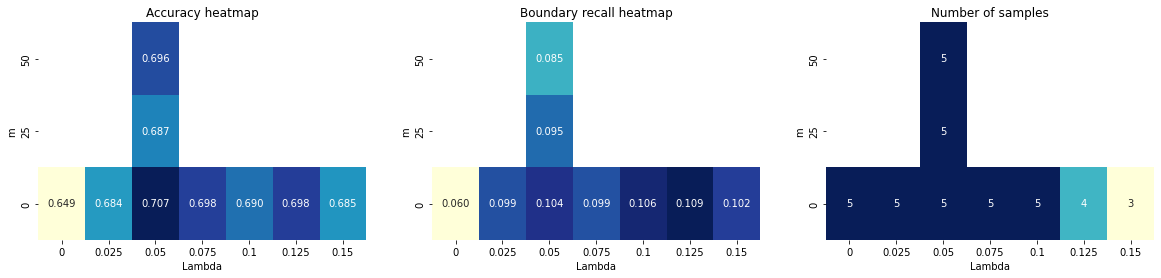

In [ ]:
plot_hyperparameters(lmbda_list, m_list, 'suim', 'val')

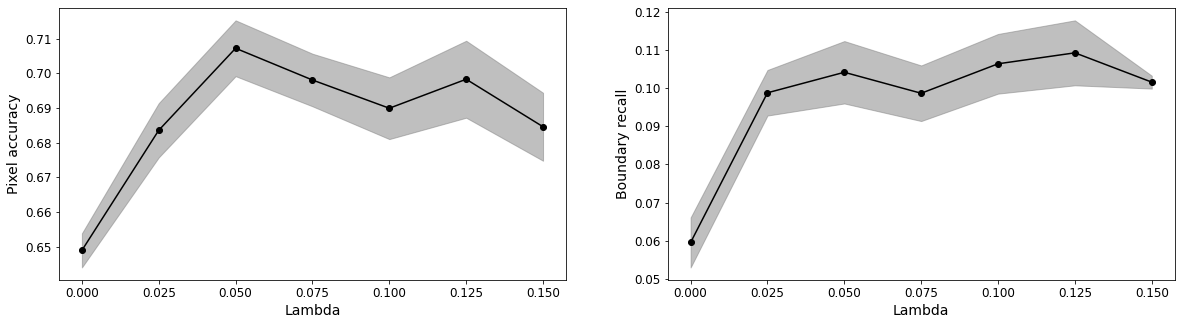

In [ ]:
plot_lmbda(lmbda_list, 0, 'suim', 'val', 'coarse')

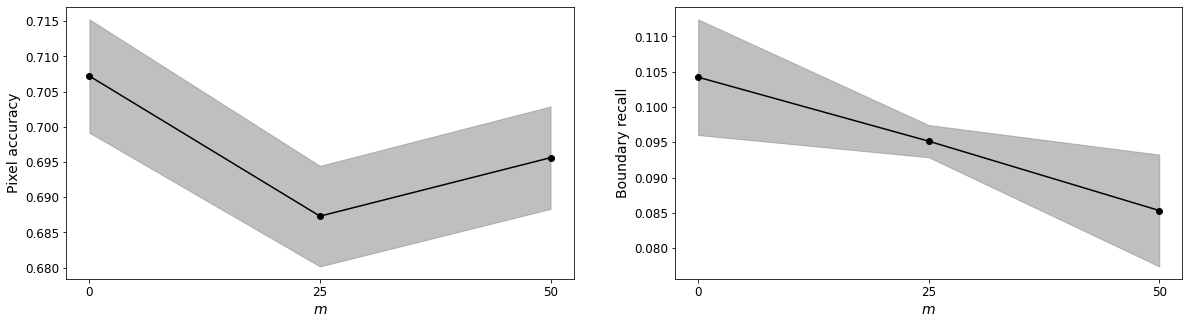

In [ ]:
plot_m(m_list, 0.05, 'suim', 'val', 'coarse')

## Hyperparameter search PanNuke
Finding the optimal hyperparameters for m (superpixel compactness) and lambda (regularization strength).

In [ ]:
m_list = [0, 25, 50]
lmbda_list = [0, 0.025, 0.05, 0.075, 0.1, 0.125]

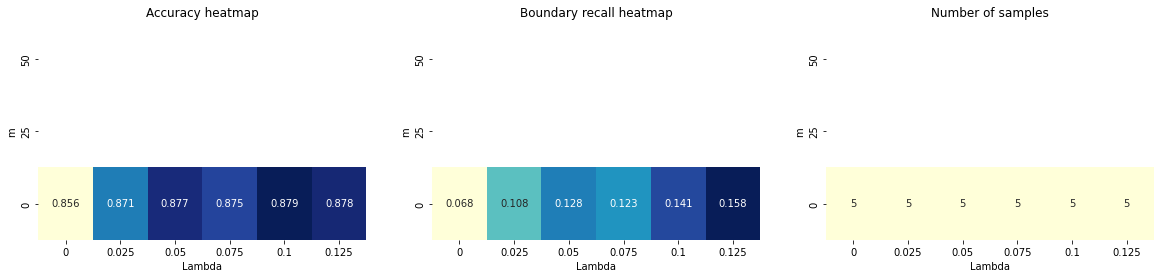

In [ ]:
plot_hyperparameters(lmbda_list, m_list, 'pannuke', 'val')

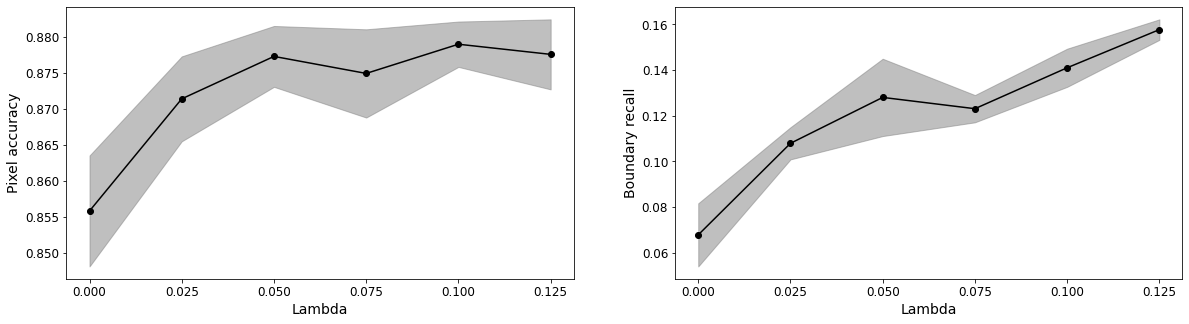

In [ ]:
plot_lmbda(lmbda_list, 0, 'pannuke', 'val', 'coarse')

## Results CityScapes

### Train and evaluate model
I train all approaches for 50 epochs, before fine-tuning on the training and validation set following algorithm 7.3 in the [Deep Learning textbook](http://www.deeplearningbook.org). During training, images are randomly cropped to a size of 512 by 512 pixels to fit into memory. At random, images are horizontally flipped.

In [ ]:
model = UNet(29).to("cuda")
loss_function = CrossEntropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, train_city_loader, val_city_loader, epochs=50, verbose=False)
finetune(model, loss_function, train_city_loader, val_city_loader, train_val_city_loader, max_epochs=15, verbose=True)
save_model(model, loss_function, data_set='cityscapes', label_set='full_fine')

#Results
results = eval_model(model, test_city_loader)
save_results(results, model, loss_function, data_set='cityscapes', label_set='full_fine', test_set='test')

100%|██████████| 50/50 [1:03:55<00:00, 76.71s/it]


Previous train loss: 0.29
Epoch: 1, 	train loss: 0.30, 	train accuracy: 90.84%
Epoch: 1, 	val loss: 0.38, 	val accuracy: 89.04%
Epoch: 2, 	train loss: 0.30, 	train accuracy: 90.85%
Epoch: 2, 	val loss: 0.39, 	val accuracy: 88.39%
Epoch: 3, 	train loss: 0.29, 	train accuracy: 90.99%
Epoch: 3, 	val loss: 0.35, 	val accuracy: 89.76%
Epoch: 4, 	train loss: 0.28, 	train accuracy: 91.25%
Epoch: 4, 	val loss: 0.36, 	val accuracy: 89.55%
Epoch: 5, 	train loss: 0.29, 	train accuracy: 90.98%
Epoch: 5, 	val loss: 0.35, 	val accuracy: 89.83%
Epoch: 6, 	train loss: 0.29, 	train accuracy: 91.09%
Epoch: 6, 	val loss: 0.33, 	val accuracy: 90.29%
Epoch: 7, 	train loss: 0.29, 	train accuracy: 91.2%
Epoch: 7, 	val loss: 0.33, 	val accuracy: 90.18%
Epoch: 8, 	train loss: 0.28, 	train accuracy: 91.27%
Epoch: 8, 	val loss: 0.32, 	val accuracy: 90.53%
Epoch: 9, 	train loss: 0.27, 	train accuracy: 91.53%
Epoch: 9, 	val loss: 0.32, 	val accuracy: 90.23%
Epoch: 10, 	train loss: 0.28, 	train accuracy: 91.5%
Epoc

### Results

Fine labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'cityscapes', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'cityscapes', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_fine', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'cityscapes', 'full_fine', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.879 ± 0.003         	Boundary recall: 0.48 ± 0.0109         
Average over 5 samples  	Accuracy: 0.882 ± 0.0028         	Boundary recall: 0.619 ± 0.0072         	ASA: 0.968 ± 0.0003
Average over 5 samples  	Accuracy: 0.882 ± 0.002         	Boundary recall: 0.636 ± 0.0092         	ASA: 0.968 ± 0.0002
Average over 5 samples  	Accuracy: 0.874 ± 0.0048         	Boundary recall: 0.651 ± 0.0048         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'cityscapes', 'full_fine', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'cityscapes', 'full_fine', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_fine', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Could not reject H_0: Regularised HCFCN acc = FCN acc.
Could not reject H_0: Regularised HCFCN acc = HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Accepted H_A: Regularised HCFCN boundary_recall > HCFCN boundary_recall.


Coarse labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'cityscapes', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'cityscapes', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_coarse', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'cityscapes', 'full_coarse', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.845 ± 0.0036         	Boundary recall: 0.34 ± 0.0044         
Average over 5 samples  	Accuracy: 0.848 ± 0.0019         	Boundary recall: 0.471 ± 0.0189         	ASA: 0.955 ± 0.0019
Average over 5 samples  	Accuracy: 0.853 ± 0.0018         	Boundary recall: 0.546 ± 0.009         	ASA: 0.964 ± 0.0003
Average over 5 samples  	Accuracy: 0.848 ± 0.0018         	Boundary recall: 0.468 ± 0.0099         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'cityscapes', 'full_coarse', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'cityscapes', 'full_coarse', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_coarse', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Accepted H_A: Regularised HCFCN acc > FCN acc.
Accepted H_A: Regularised HCFCN acc > HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Accepted H_A: Regularised HCFCN boundary_recall > HCFCN boundary_recall.


### Plot example results

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)

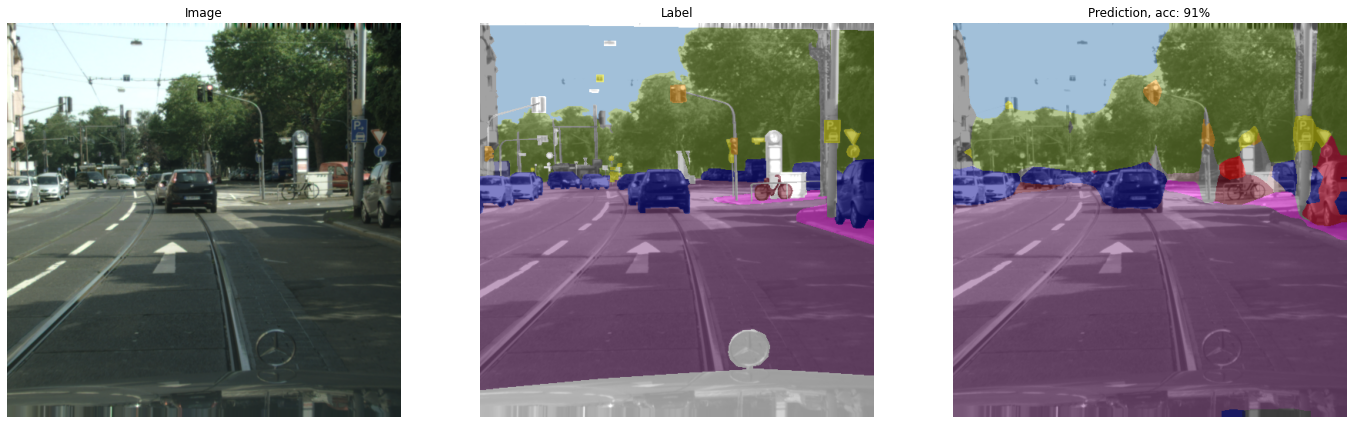

In [ ]:
idx=6
model = SegModel(encoder, classifier, interpolate).to("cuda")
model = load_model(1, model, 'cross_entropy', 'cityscapes', 'full_coarse')
show_predict(model, test_city, city_classes, idx=idx, crop=512)

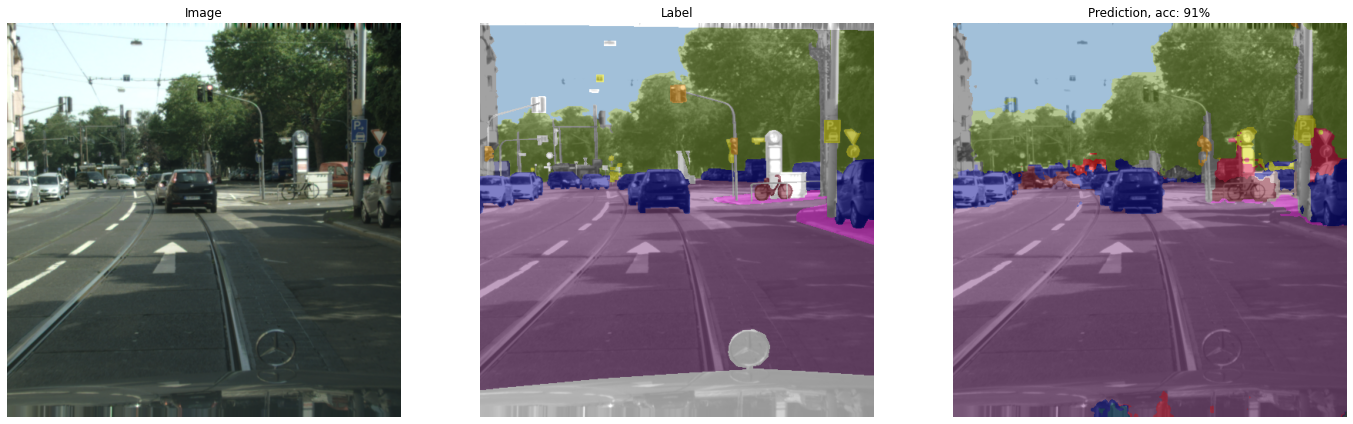

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'cityscapes', 'full_coarse')
show_predict(model, test_city, city_classes, idx=idx, crop=512)

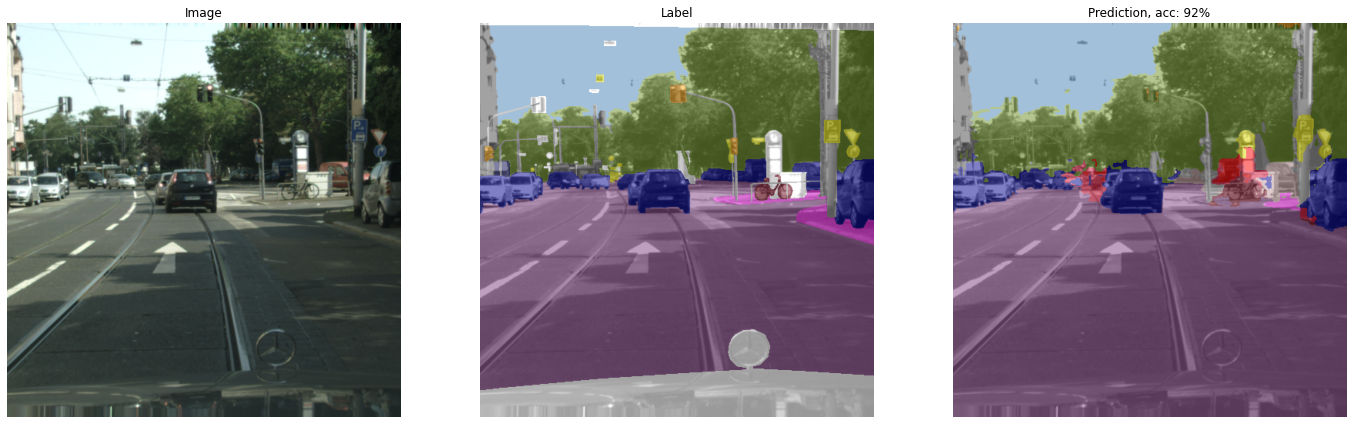

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_coarse')
show_predict(model, test_city, city_classes, idx=idx, crop=512)

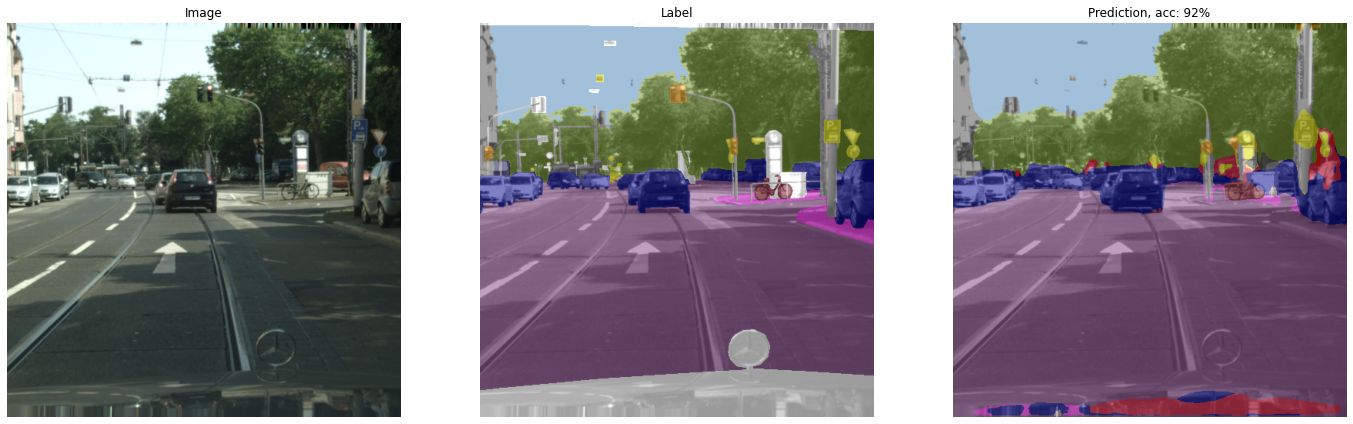

In [ ]:
model = UNet(29).to("cuda")
model = load_model(1, model, 'cross_entropy', 'cityscapes', 'full_coarse')
show_predict(model, test_city, city_classes, idx=idx, crop=512)

## Results SUIM

### Train and evaluate model
I train all approaches for 75 epochs, before fine-tuning on the training and validation set following algorithm 7.3 in the [Deep Learning textbook](http://www.deeplearningbook.org). During training, images are randomly cropped to a size of 512 by 512 pixels to fit into memory. At random, images are horizontally flipped.

In [ ]:
model = UNet(7).to("cuda")
loss_function = CrossEntropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, train_suim_loader, val_suim_loader, epochs=75, verbose=False)
finetune(model, loss_function, train_suim_loader, val_suim_loader, train_val_suim_loader, max_epochs=15, verbose=True)
save_model(model, loss_function, data_set='suim', label_set='full_fine')

#Results
results = eval_model(model, test_suim_loader)
save_results(results, model, loss_function, data_set='suim', label_set='full_fine', test_set='test')

100%|██████████| 75/75 [43:51<00:00, 35.08s/it]


Previous train loss: 0.49
Epoch: 1, 	train loss: 0.63, 	train accuracy: 78.37%
Epoch: 1, 	val loss: 1.17, 	val accuracy: 66.92%
Epoch: 2, 	train loss: 0.60, 	train accuracy: 79.56%
Epoch: 2, 	val loss: 1.21, 	val accuracy: 67.02%
Epoch: 3, 	train loss: 0.59, 	train accuracy: 79.47%
Epoch: 3, 	val loss: 1.28, 	val accuracy: 64.53%
Epoch: 4, 	train loss: 0.61, 	train accuracy: 78.8%
Epoch: 4, 	val loss: 1.16, 	val accuracy: 67.6%
Epoch: 5, 	train loss: 0.56, 	train accuracy: 80.4%
Epoch: 5, 	val loss: 1.24, 	val accuracy: 67.5%
Epoch: 6, 	train loss: 0.59, 	train accuracy: 79.5%
Epoch: 6, 	val loss: 1.23, 	val accuracy: 66.15%
Epoch: 7, 	train loss: 0.59, 	train accuracy: 79.33%
Epoch: 7, 	val loss: 1.22, 	val accuracy: 65.72%
Epoch: 8, 	train loss: 0.56, 	train accuracy: 80.32%
Epoch: 8, 	val loss: 1.22, 	val accuracy: 67.67%
Epoch: 9, 	train loss: 0.56, 	train accuracy: 80.7%
Epoch: 9, 	val loss: 1.17, 	val accuracy: 68.43%
Epoch: 10, 	train loss: 0.55, 	train accuracy: 80.6%
Epoch: 10

### Results

Precise labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'suim', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'suim', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.05_0', 'suim', 'full_fine', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'suim', 'full_fine', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.711 ± 0.01         	Boundary recall: 0.066 ± 0.0043         
Average over 5 samples  	Accuracy: 0.708 ± 0.0108         	Boundary recall: 0.144 ± 0.0105         	ASA: 0.974 ± 0.0008
Average over 5 samples  	Accuracy: 0.729 ± 0.0034         	Boundary recall: 0.187 ± 0.007         	ASA: 0.985 ± 0.0001
Average over 5 samples  	Accuracy: 0.688 ± 0.0156         	Boundary recall: 0.131 ± 0.0115         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'suim', 'full_fine', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'suim', 'full_fine', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.05_0', 'suim', 'full_fine', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Accepted H_A: Regularised HCFCN acc > FCN acc.
Accepted H_A: Regularised HCFCN acc > HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Accepted H_A: Regularised HCFCN boundary_recall > HCFCN boundary_recall.


Coarse labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'suim', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'suim', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.05_0', 'suim', 'full_coarse', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'suim', 'full_coarse', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.684 ± 0.0078         	Boundary recall: 0.048 ± 0.0024         
Average over 5 samples  	Accuracy: 0.635 ± 0.0467         	Boundary recall: 0.078 ± 0.0209         	ASA: 0.968 ± 0.0008
Average over 5 samples  	Accuracy: 0.704 ± 0.0066         	Boundary recall: 0.125 ± 0.0063         	ASA: 0.985 ± 0.0001
Average over 5 samples  	Accuracy: 0.651 ± 0.0138         	Boundary recall: 0.074 ± 0.0068         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'suim', 'full_coarse', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'suim', 'full_coarse', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.05_0', 'suim', 'full_coarse', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Accepted H_A: Regularised HCFCN acc > FCN acc.
Accepted H_A: Regularised HCFCN acc > HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Accepted H_A: Regularised HCFCN boundary_recall > HCFCN boundary_recall.


### Plot example results

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 7)
decoder = HCDecoder(tau=0.07, sim_feat=48)

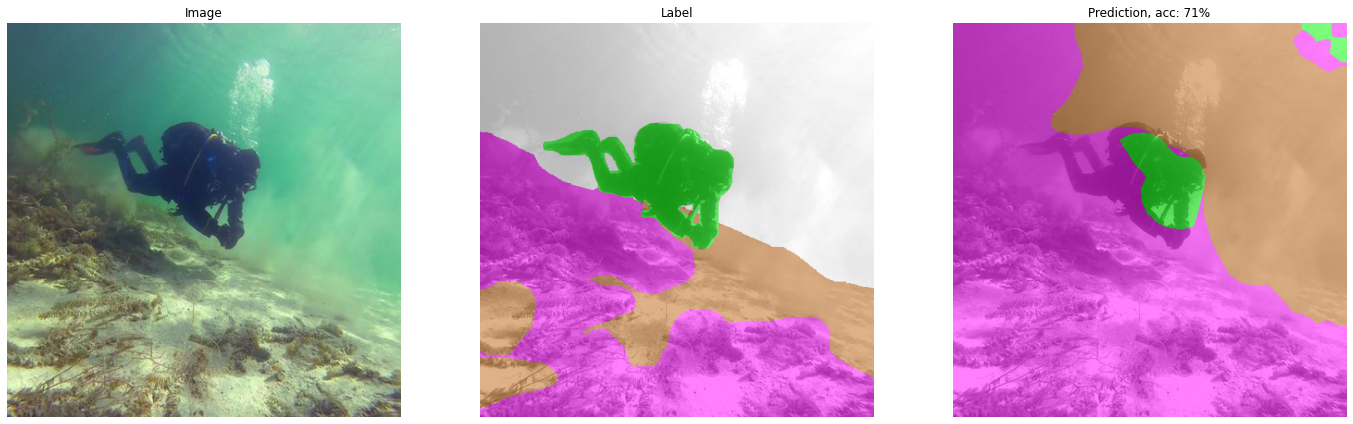

In [ ]:
idx=17
model = SegModel(encoder, classifier, interpolate).to("cuda")
model = load_model(1, model, 'cross_entropy', 'suim', 'full_coarse')
show_predict(model, test_suim, suim_classes, idx=idx, crop=512)

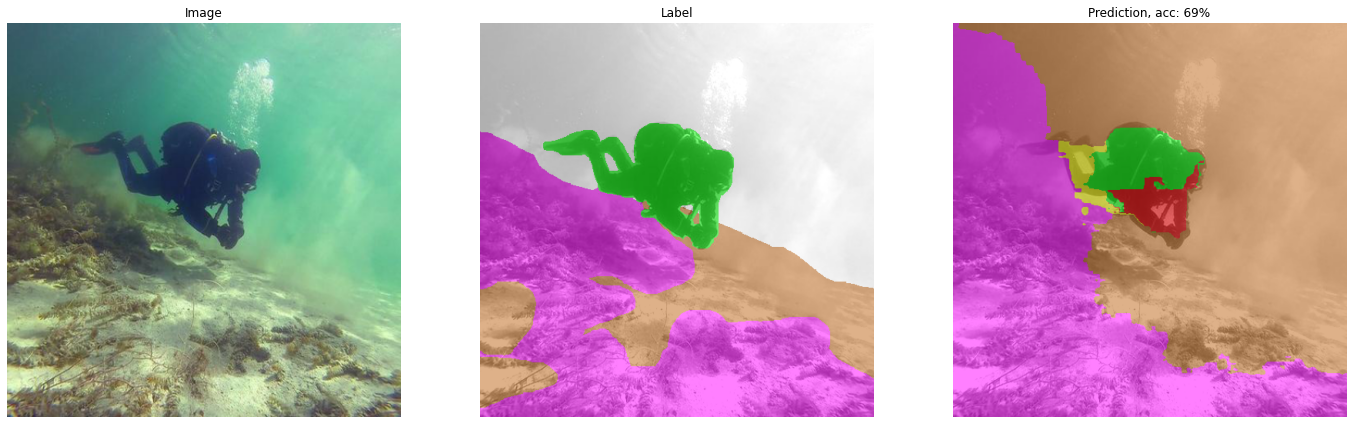

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'suim', 'full_coarse')
show_predict(model, test_suim, suim_classes, idx=idx, crop=512)

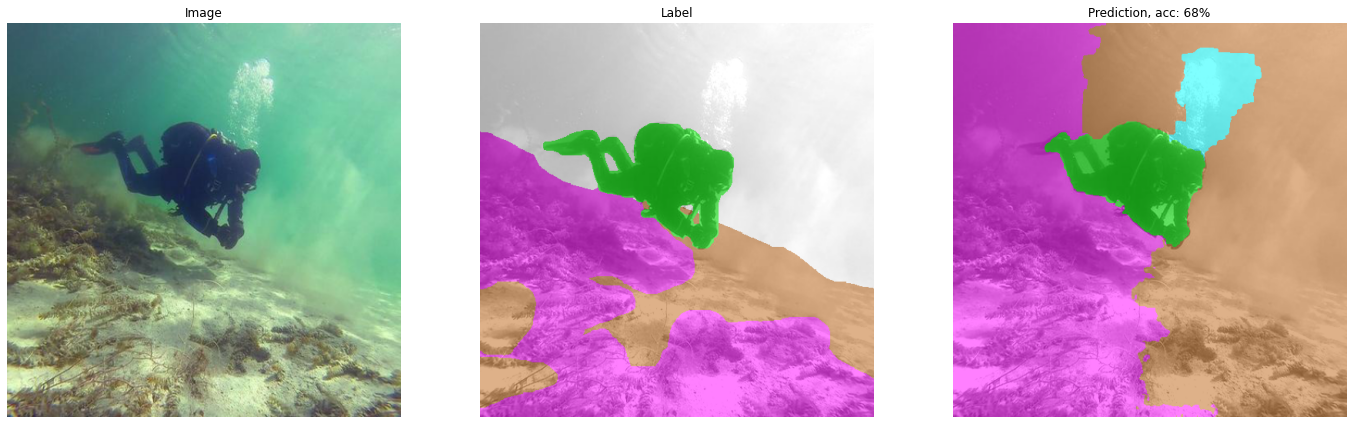

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'reg_cross_entropy_0.05_0', 'suim', 'full_coarse')
show_predict(model, test_suim, suim_classes, idx=idx, crop=512)

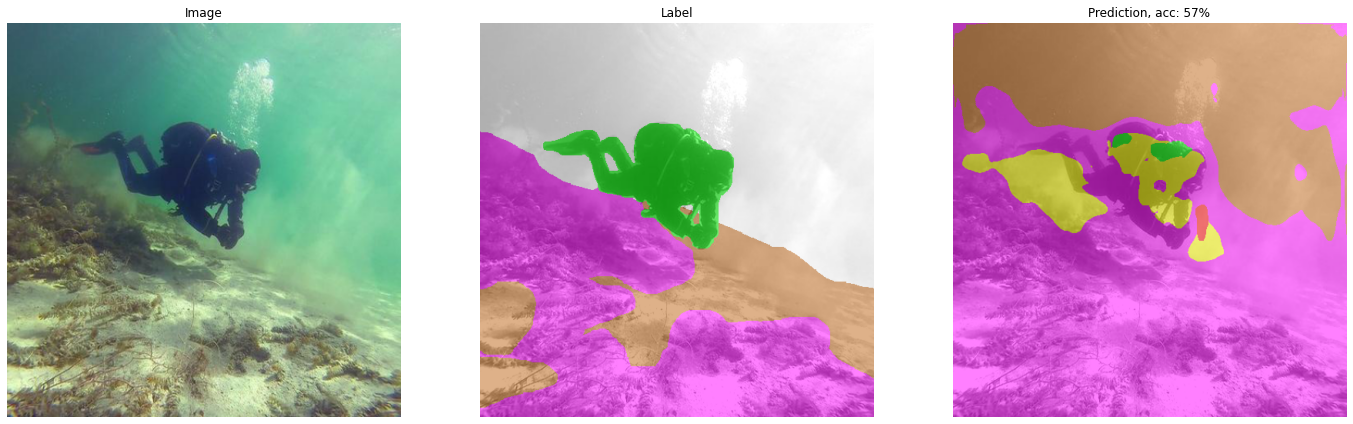

In [ ]:
model = UNet(7).to("cuda")
model = load_model(1, model, 'cross_entropy', 'suim', 'full_coarse')
show_predict(model, test_suim, suim_classes, idx=idx, crop=512)

## PanNuke results

### Train and evaluate model
I train all approaches for 50 epochs, before fine-tuning on the training and validation set following algorithm 7.3 in the [Deep Learning textbook](http://www.deeplearningbook.org). During training, images are randomly cropped to a size of 512 by 512 pixels to fit into memory. At random, images are horizontally flipped.

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 6)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
loss_function = CrossEntropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, train_pannuke_loader, val_pannuke_loader, epochs=50, verbose=True)
save_model(model, loss_function, data_set='pannuke', label_set='fine')

### Results

Fine labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'pannuke', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'pannuke', 'full_fine', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.1_0', 'pannuke', 'full_fine', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'pannuke', 'full_fine', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.902 ± 0.0008         	Boundary recall: 0.287 ± 0.0026         
Average over 5 samples  	Accuracy: 0.893 ± 0.0136         	Boundary recall: 0.347 ± 0.0541         	ASA: 0.942 ± 0.0112
Average over 5 samples  	Accuracy: 0.891 ± 0.0072         	Boundary recall: 0.351 ± 0.0303         	ASA: 0.949 ± 0.0036
Average over 5 samples  	Accuracy: 0.924 ± 0.001         	Boundary recall: 0.512 ± 0.0109         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'pannuke', 'full_fine', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'pannuke', 'full_fine', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.1_0', 'pannuke', 'full_fine', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Could not reject H_0: Regularised HCFCN acc = FCN acc.
Could not reject H_0: Regularised HCFCN acc = HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Could not reject H_0: Regularised HCFCN boundary_recall = HCFCN boundary_recall.


Coarse labels

In [ ]:
results = load_results('FCN', 'cross_entropy', 'pannuke', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'cross_entropy', 'pannuke', 'full_coarse', 'test')
print_results(results)
results = load_results('HCFCN', 'reg_cross_entropy_0.1_0', 'pannuke', 'full_coarse', 'test')
print_results(results)
results = load_results('UNet', 'cross_entropy', 'pannuke', 'full_coarse', 'test')
print_results(results)

Average over 5 samples  	Accuracy: 0.886 ± 0.0006         	Boundary recall: 0.122 ± 0.0057         
Average over 5 samples  	Accuracy: 0.853 ± 0.0123         	Boundary recall: 0.062 ± 0.0084         	ASA: 0.907 ± 0.0084
Average over 5 samples  	Accuracy: 0.869 ± 0.0051         	Boundary recall: 0.144 ± 0.0094         	ASA: 0.943 ± 0.0036
Average over 5 samples  	Accuracy: 0.881 ± 0.0019         	Boundary recall: 0.063 ± 0.0073         


In [ ]:
#Test significance
alpha = 0.05
results_fcn = load_results('FCN', 'cross_entropy', 'pannuke', 'full_coarse', 'test', avg=False)
results_hc = load_results('HCFCN', 'cross_entropy', 'pannuke', 'full_coarse', 'test', avg=False)
results_reg_hc = load_results('HCFCN', 'reg_cross_entropy_0.1_0', 'pannuke', 'full_coarse', 'test', avg=False)

for metric in ['acc', 'boundary_recall']:
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_fcn[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > FCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = FCN {metric}.")
    _, p = stats.mannwhitneyu(results_reg_hc[metric], results_hc[metric], alternative='greater')
    if (p/2) < alpha:
        print(f"Accepted H_A: Regularised HCFCN {metric} > HCFCN {metric}.")
    else:
        print(f"Could not reject H_0: Regularised HCFCN {metric} = HCFCN {metric}.")

Could not reject H_0: Regularised HCFCN acc = FCN acc.
Accepted H_A: Regularised HCFCN acc > HCFCN acc.
Accepted H_A: Regularised HCFCN boundary_recall > FCN boundary_recall.
Accepted H_A: Regularised HCFCN boundary_recall > HCFCN boundary_recall.


### Plot example results

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 6)
decoder = HCDecoder(tau=0.07, sim_feat=48)

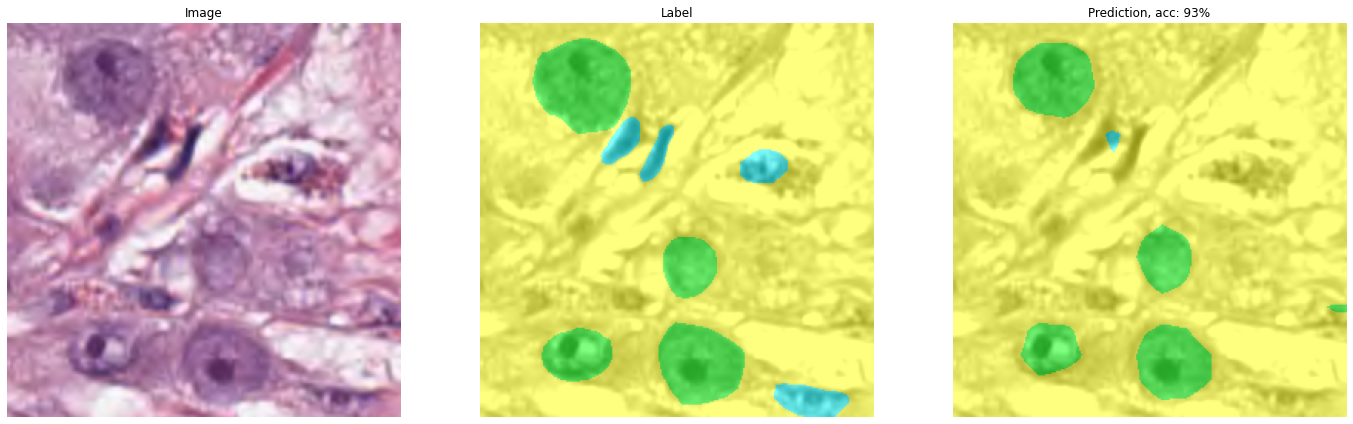

In [ ]:
idx=1
model = SegModel(encoder, classifier, interpolate).to("cuda")
model = load_model(1, model, 'cross_entropy', 'pannuke', 'full_coarse')
show_predict(model, test_pannuke, pannuke_classes, idx=idx)

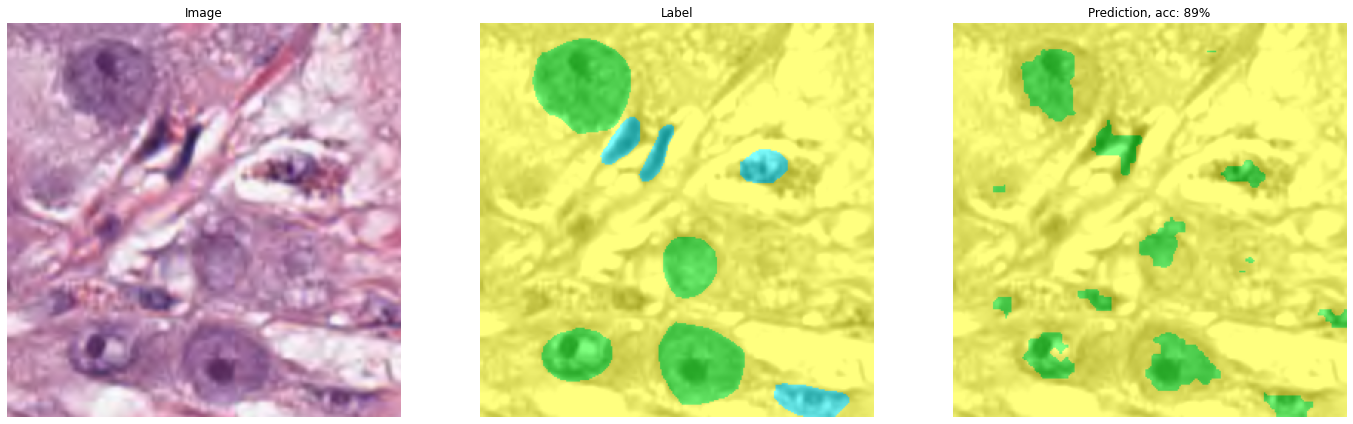

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'pannuke', 'full_coarse')
show_predict(model, test_pannuke, pannuke_classes, idx=idx)

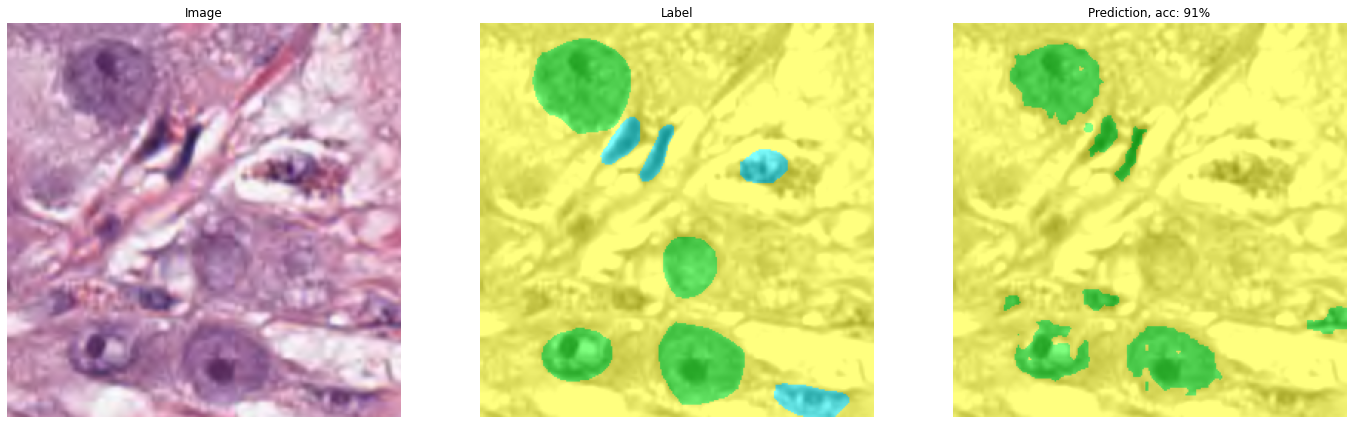

In [ ]:
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'reg_cross_entropy_0.1_0', 'pannuke', 'full_coarse')
show_predict(model, test_pannuke, pannuke_classes, idx=idx)

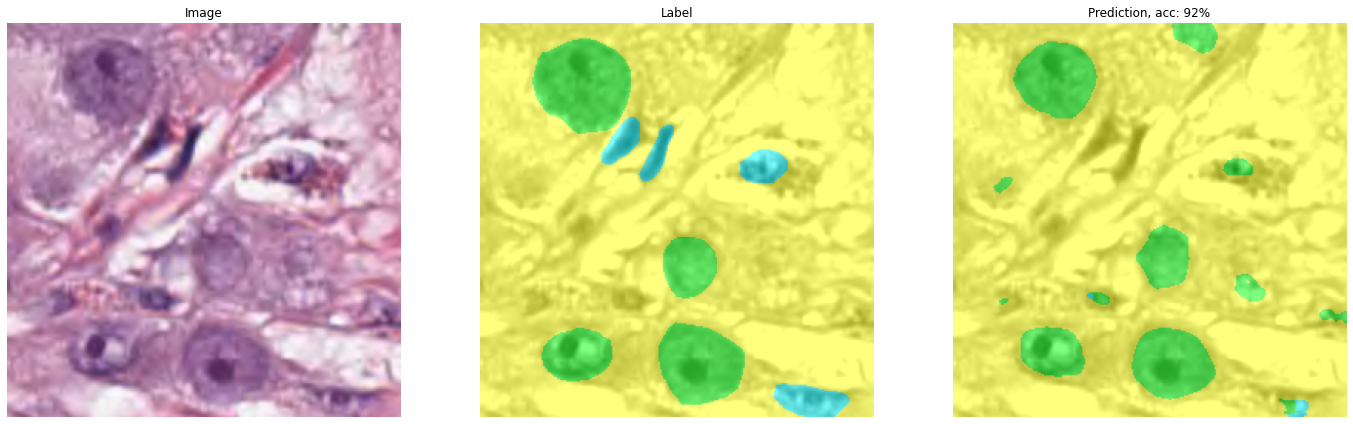

In [ ]:
model = UNet(6).to("cuda")
model = load_model(1, model, 'cross_entropy', 'pannuke', 'full_coarse')
show_predict(model, test_pannuke, pannuke_classes, idx=idx)

## Boundary alignment
The regularization term aims to improve boundary alignment. The improved boundary recall suggests the regularization term is effective in doing so. Let's investigate the role of the superpixels in improving the boundary alignment.

Cityscapes

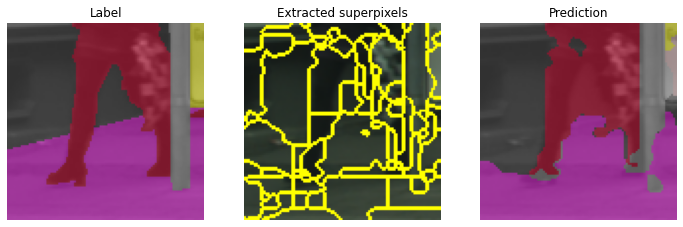

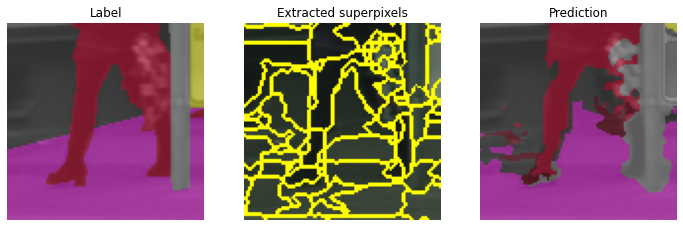

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'cityscapes', 'full_coarse')
show_boundary_alignment(model, val_city, city_classes, 90, wx=175, wy=275, hx=250, hy=350)
model = load_model(1, model, 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_coarse')
show_boundary_alignment(model, val_city, city_classes, 90, wx=175, wy=275, hx=250, hy=350)

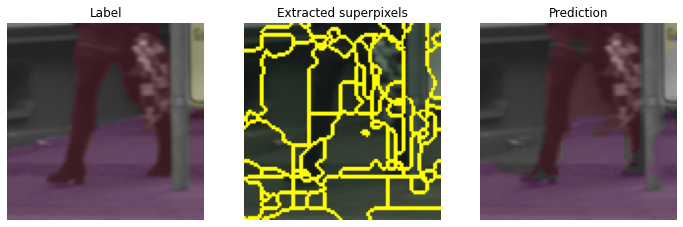

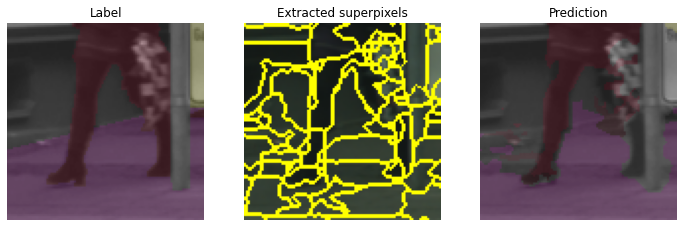

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'cityscapes', 'full_coarse')
show_boundary_alignment(model, val_city, city_classes, 90, wx=175, wy=275, hx=250, hy=350)
model = load_model(1, model, 'reg_cross_entropy_0.075_0', 'cityscapes', 'full_coarse')
show_boundary_alignment(model, val_city, city_classes, 90, wx=175, wy=275, hx=250, hy=350)

PanNuke

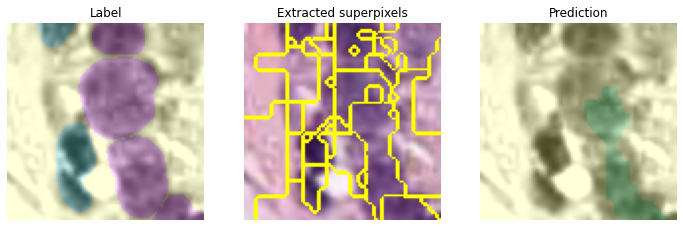

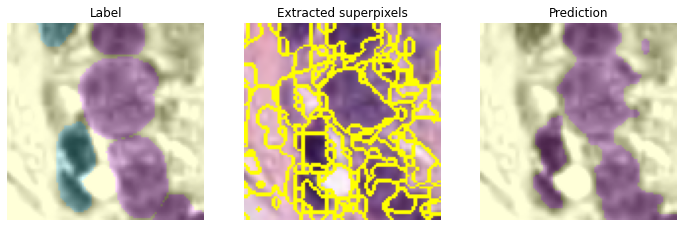

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 6)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'pannuke', 'full_coarse')
show_boundary_alignment(model, val_pannuke, pannuke_classes, 3, wx=50, wy=150, hx=0, hy=100)
model = load_model(1, model, 'reg_cross_entropy_0.1_0', 'pannuke', 'full_coarse')
show_boundary_alignment(model, val_pannuke, pannuke_classes, 3, wx=50, wy=150, hx=0, hy=100)

SUIM

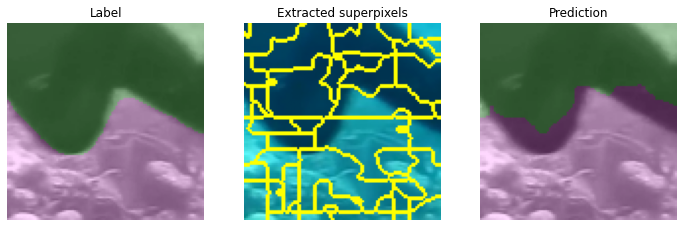

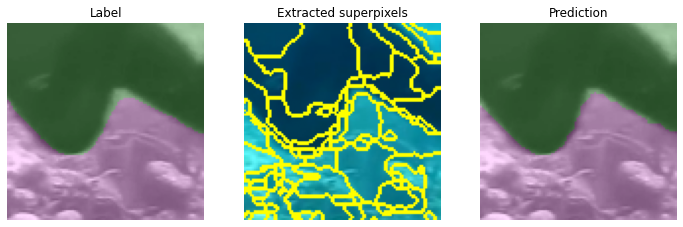

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 7)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
model = load_model(1, model, 'cross_entropy', 'suim', 'full_coarse')
show_boundary_alignment(model, val_suim, suim_classes, 2, wx=412, wy=512, hx=200, hy=300)
model = load_model(1, model, 'reg_cross_entropy_0.05_0', 'suim', 'full_coarse')
show_boundary_alignment(model, val_suim, suim_classes, 2, wx=412, wy=512, hx=200, hy=300)

## SLIC-superpixels
The regularization term encourages the superpixels to be SLIC-superpixels. We are interested in the SLIC-superpixels the regularization term encourages. We train HCFCN-16 on the regularization term exclusively, without the supervised loss. The superpixels of the resulting model are considered SLIC-superpixels. I compare these SLIC-superpixels to the superpixels when trained on fine labels, coarse labels and coarse labels with regularization. Achievable Segmentation Accuracy (ASA) is used to compare the superpixels.

### Train and evaluate with SLIC loss

In [ ]:
nr_epochs = 15
train_loader = train_city_loader
val_loader = val_city_loader
num_classes = 29
m=0

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, num_classes)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder)

#Train model
loss_function = SLIC(m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
model.to("cuda").train()
min_val_loss = 10000

for epoch in tqdm(range(nr_epochs)):
    for image, label in train_loader:
        image, label = image.to("cuda"), label.to("cuda")

        assignments, output = model(image)
        loss = loss_function(assignments, output, image, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ###Validation###
    tmp_val_loss = []
    with torch.no_grad():
        for image, label in val_loader:
            image, label = image.to("cuda"), label.to("cuda")

            assignments, output = model(image)
            loss = loss_function(assignments, output, image, label)
            tmp_val_loss.append(loss.item())

    val_loss = sum(tmp_val_loss) / len(tmp_val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), '/content/best_model.pt')

#Load best model
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
save_model(model, 'cityscapes', 'slic', True, lmbda=None, m=m)
results = eval_model(model, val_city_loader)
save_results(results, 'cityscapes', 'val', 'slic', True, lmbda=None, m=m)

### Results

CityScapes

In [ ]:
results = load_results('cityscapes', 'val', 'fine', True, lmbda=0, m=0)
print_results(results)
results = load_results('cityscapes', 'val', 'coarse', True, lmbda=0, m=0)
print_results(results)
results = load_results('cityscapes', 'val', 'slic', True, lmbda=None, m=0)
print_results(results)
results = load_results('cityscapes', 'val', 'coarse', True, lmbda=0.075, m=0)
print_results(results)

Average over 5 samples  	Accuracy: 0.897 ± 0.0021         	Boundary recall: 0.621 ± 0.0054         	ASA: 0.973 ± 0.0008
Average over 5 samples  	Accuracy: 0.869 ± 0.0016         	Boundary recall: 0.48 ± 0.0061         	ASA: 0.962 ± 0.0019
Average over 5 samples  	Accuracy: 0.021 ± 0.0098         	Boundary recall: 0.799 ± 0.0331         	ASA: 0.962 ± 0.0012
Average over 5 samples  	Accuracy: 0.875 ± 0.0017         	Boundary recall: 0.534 ± 0.0077         	ASA: 0.97 ± 0.0001


SUIM

In [ ]:
results = load_results('suim', 'val', 'fine', True, lmbda=0, m=0)
print_results(results)
results = load_results('suim', 'val', 'coarse', True, lmbda=0, m=0)
print_results(results)
results = load_results('suim', 'val', 'slic', True, lmbda=None, m=0)
print_results(results)
results = load_results('suim', 'val', 'coarse', True, lmbda=0.05, m=0)
print_results(results)

Average over 5 samples  	Accuracy: 0.693 ± 0.008         	Boundary recall: 0.112 ± 0.015         	ASA: 0.975 ± 0.0008
Average over 5 samples  	Accuracy: 0.649 ± 0.0049         	Boundary recall: 0.06 ± 0.0066         	ASA: 0.968 ± 0.0008
Average over 5 samples  	Accuracy: 0.147 ± 0.0702         	Boundary recall: 0.391 ± 0.0275         	ASA: 0.986 ± 0.0001
Average over 5 samples  	Accuracy: 0.707 ± 0.008         	Boundary recall: 0.104 ± 0.0082         	ASA: 0.986 ± 0.0001


## Classification error
As stated before, ASA measures the maximum accuracy that can be achieved given the superpixels. The realised accuracy is given by pixel accuracy. This allows us to define classification error as the difference between ASA and pixel accuracy. The regularization term directly impacts ASA, as the regularization term is aimed at the superpixels. I investigate the indirect impact of the regularization term on the classification error.

In [ ]:
results = load_results('cityscapes', 'val', 'coarse', True, lmbda=0, m=0)
print_results(results)
results = load_results('cityscapes', 'val', 'coarse', True, lmbda=0.075, m=0)
print_results(results)

Average over 5 samples  	Accuracy: 0.869 ± 0.0016         	Boundary recall: 0.48 ± 0.0061         	ASA: 0.962 ± 0.0019
Average over 5 samples  	Accuracy: 0.875 ± 0.0017         	Boundary recall: 0.534 ± 0.0077         	ASA: 0.97 ± 0.0001


In [ ]:
results = load_results('suim', 'val', 'coarse', True, lmbda=0, m=0)
print_results(results)
results = load_results('suim', 'val', 'coarse', True, lmbda=0.05, m=0)
print_results(results)

Average over 5 samples  	Accuracy: 0.649 ± 0.0049         	Boundary recall: 0.06 ± 0.0066         	ASA: 0.968 ± 0.0008
Average over 5 samples  	Accuracy: 0.707 ± 0.008         	Boundary recall: 0.104 ± 0.0082         	ASA: 0.986 ± 0.0001


## Cityscapes subset
The effectiveness of regularization is expected to correlate inversely with the number of training samples. The Cityscapes dataset has more samples than the SUIM dataset. Furthermore, each sample in the Cityscapes dataset has double the horizontal resolution compared to the SUIM dataset. This could explain the discrepancy in the effectiveness of regularization between the Cityscapes and SUIM datasets. We test this hypothesis by training HCFCN-16 with and without regularization on various subsets of the Cityscapes dataset.

In [ ]:
#Get subset
nr_samples = 592
nr_epochs = int(50 * np.sqrt((2369/nr_samples)))

idx = random.sample(range(len(coarse_train_city)), nr_samples)
small_coarse_train_city = torch.utils.data.Subset(coarse_train_city, idx)
small_coarse_train_city_loader = DataLoader(small_coarse_train_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)

In [ ]:
#Train HCFCN-16 on subset
model = train_run(small_coarse_train_city_loader, coarse_val_city_loader, True, lmbda=0, m=0, epochs=nr_epochs)
save_model(model, 'cityscapes', f'coarse_{nr_samples}', True, lmbda=0, m=0)
results = eval_model(model, val_city_loader)
save_results(results, 'cityscapes', 'val', f'coarse_{nr_samples}', True, lmbda=0, m=0)

In [ ]:
#Train regularized HCFCN-16 on subset
model = train_run(small_coarse_train_city_loader, coarse_val_city_loader, True, lmbda=0.075, m=0, epochs=nr_epochs)
save_model(model, 'cityscapes', f'coarse_{nr_samples}', True, lmbda=0.075, m=0)
results = eval_model(model, val_city_loader)
save_results(results, 'cityscapes', 'val', f'coarse_{nr_samples}', True, lmbda=0.075, m=0)

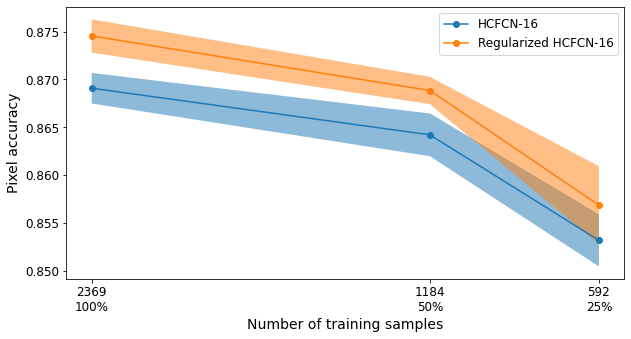

In [ ]:
plot_subset(len(coarse_train_city), [1184, 592], 'cityscapes', 'val', 'coarse', 0.075, 0)

## Time training epoch
Let's time training for a single epoch using the different approaches.

In [ ]:
def time_epoch(model, loss_function):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    model.train()
    times = []
    for epoch in range(6):
        start = time.time()
        for image, label in train_city_loader:
            image, label = image.to("cuda"), label.to("cuda")
            assignments, output = model(image)

            loss = loss_function(assignments, output, image, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        times.append(time.time()-start)

    return np.average(times[1:]), np.std(times[1:])

Training time FCN

In [ ]:
#Initialize FCN
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
model = SegModel(encoder, classifier, interpolate).cuda()
loss_function = CrossEntropy()

#Train model
avg, std = time_epoch(model, loss_function)
print(f"Average epoch training time {round(avg, 1)} ± {round(std, 1)} seconds")

Training time HCFCN-16

In [ ]:
#Initialize HCFCN-16
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).cuda()
loss_function = CrossEntropy()

#Train model
avg, std = time_epoch(model, loss_function)
print(f"Average epoch training time {round(avg, 1)} ± {round(std, 1)} seconds")

Training time regularized HCFCN-16

In [ ]:
#Initialize regularized HCFCN-16
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).cuda()
loss_function = RegularisedCrossEntropy(lmbda=0.075, m=0)

#Train model
avg, std = time_epoch(model, loss_function)
print(f"Average epoch training time {round(avg, 1)} ± {round(std, 1)} seconds")

## Vary level of coarseness
I investigate the impact of intermediate levels of coarseness. The intermediate levels of coarseness are obtained by varying the number of eroded pixels.

In [ ]:
def plot_coarseness(model_list, erode_list, data_set, test_set, full_c=25):
    model_acc = {model[0]:([], []) for model in model_list}
    model_br = {model[0]:([], []) for model in model_list}

    for erode in erode_list:
        if erode==1:
            tmp_label_set = 'full_fine'
        elif erode==full_c:
            tmp_label_set = 'full_coarse'
        else:
            tmp_label_set = 'full_coarse' + f'_{erode}'

        for model in model_list:
            results = load_results(model[1], model[2], data_set, tmp_label_set, test_set)
            model_acc[model[0]][0].append(results['acc'][0])
            model_acc[model[0]][1].append(results['acc'][1])
            model_br[model[0]][0].append(results['boundary_recall'][0])
            model_br[model[0]][1].append(results['boundary_recall'][1])

    #Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
    erode_list = (np.array(erode_list) - 1) / 2
    for model in model_list:
        ax1.plot(erode_list, model_acc[model[0]][0], 'o-', label=model[0])
        ax1.fill_between(erode_list, np.array(model_acc[model[0]][0]) + np.array(model_acc[model[0]][1]),
                        np.array(model_acc[model[0]][0]) - np.array(model_acc[model[0]][1]), alpha=0.5)

        ax2.plot(erode_list, model_br[model[0]][0], 'o-', label=model[0])
        ax2.fill_between(erode_list, np.array(model_br[model[0]][0]) + np.array(model_br[model[0]][1]),
                        np.array(model_br[model[0]][0]) - np.array(model_br[model[0]][1]), alpha=0.5)

    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax1.set_ylabel('Pixel accuracy', fontsize=14)
    ax2.set_xlabel("Number of eroded pixels", fontsize=14)
    ax2.set_ylabel('Boundary recall', fontsize=14)
    ax1.legend(fontsize=14, bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=2)
    plt.show()

### Cityscapes dataset

Generate coarse dataset

In [ ]:
erode=5

#Build datasets
coarse_train_city = DataSet('Datasets/Cityscapes/Train/Images/', 'Datasets/Cityscapes/Train/Labels/', train=True, coarse=True, erode=erode, imp=0.005)
coarse_val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Labels/', img_size=(512, 1024), coarse=True, erode=erode, imp=0.005)
coarse_train_val_city = DataSet('Datasets/Cityscapes/Val/Images/', 'Datasets/Cityscapes/Val/Labels/', train=True, coarse=True, erode=erode, imp=0.005)
coarse_train_val_city = ConcatDataset((coarse_train_city, coarse_train_val_city))

coarse_train_city_loader = DataLoader(coarse_train_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=16)
coarse_val_city_loader = DataLoader(coarse_val_city, batch_size=20, shuffle=False, num_workers=2, prefetch_factor=10)
coarse_train_val_city_loader = DataLoader(coarse_train_val_city, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=16)

Train model on coarse labels

In [ ]:
#Initialize model
encoder = ResNet34Encoder()
classifier = FCNHead(256, 29)
decoder = HCDecoder(tau=0.07, sim_feat=48)
model = SegModel(encoder, classifier, decoder).to("cuda")
#model = SegModel(encoder, classifier, interpolate).to("cuda")
#model = UNet(29).to("cuda")
#loss_function = CrossEntropy()
loss_function = RegularisedCrossEntropy(lmbda=0.075, m=0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, coarse_train_city_loader, coarse_val_city_loader, epochs=50, verbose=False)
finetune(model, loss_function, coarse_train_city_loader, coarse_val_city_loader, coarse_train_val_city_loader, max_epochs=15, verbose=True)
save_model(model, loss_function, data_set='cityscapes', label_set=f'full_coarse_{erode}')

#Results
results = eval_model(model, test_city_loader)
save_results(results, model, loss_function, data_set='cityscapes', label_set=f'full_coarse_{erode}', test_set='test')

100%|██████████| 50/50 [1:03:31<00:00, 76.23s/it]


Previous train loss: 0.33
Epoch: 1, 	train loss: 0.37, 	train accuracy: 93.7%
Epoch: 1, 	val loss: 0.45, 	val accuracy: 91.26%
Epoch: 2, 	train loss: 0.35, 	train accuracy: 94.02%
Epoch: 2, 	val loss: 0.41, 	val accuracy: 92.33%
Epoch: 3, 	train loss: 0.35, 	train accuracy: 94.01%
Epoch: 3, 	val loss: 0.42, 	val accuracy: 92.21%
Epoch: 4, 	train loss: 0.35, 	train accuracy: 94.12%
Epoch: 4, 	val loss: 0.40, 	val accuracy: 92.67%
Epoch: 5, 	train loss: 0.34, 	train accuracy: 94.21%
Epoch: 5, 	val loss: 0.40, 	val accuracy: 92.59%
Epoch: 6, 	train loss: 0.34, 	train accuracy: 94.36%
Epoch: 6, 	val loss: 0.40, 	val accuracy: 92.75%
Epoch: 7, 	train loss: 0.33, 	train accuracy: 94.48%
Epoch: 7, 	val loss: 0.38, 	val accuracy: 93.05%
Epoch: 8, 	train loss: 0.33, 	train accuracy: 94.67%
Epoch: 8, 	val loss: 0.37, 	val accuracy: 93.33%
Epoch: 9, 	train loss: 0.32, 	train accuracy: 94.85%
Epoch: 9, 	val loss: 0.38, 	val accuracy: 92.93%
Epoch: 10, 	train loss: 0.33, 	train accuracy: 94.73%
Epo

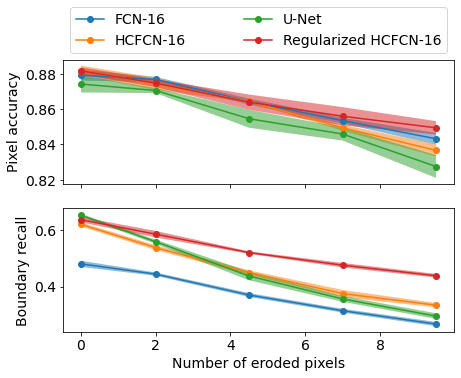

In [ ]:
#Plotting
model_list = [('FCN-16', 'FCN', 'cross_entropy'),
              ('HCFCN-16', 'HCFCN', 'cross_entropy'),
              ('U-Net', 'UNet', 'cross_entropy'),
              ('Regularized HCFCN-16', 'HCFCN', 'reg_cross_entropy_0.075_0')]

erode_list = [1, 5, 10, 15, 20]

plot_coarseness(model_list, erode_list, 'cityscapes', 'test')

### SUIM dataset

Generate coarse dataset

In [ ]:
erode=20

#Build datasets
coarse_train_suim = DataSet('Datasets/SUIM/Train/Images/', 'Datasets/SUIM/Train/Labels/', train=True, coarse=True, erode=erode, imp=0.005)
coarse_val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/', coarse=True, erode=erode, imp=0.005)
coarse_train_val_suim = DataSet('Datasets/SUIM/Val/Images/', 'Datasets/SUIM/Val/Labels/', train=True, coarse=True, erode=erode, imp=0.005)
coarse_train_val_suim = ConcatDataset((coarse_train_suim, coarse_train_val_suim))

#Build DataLoaders
coarse_train_suim_loader = DataLoader(coarse_train_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)
coarse_val_suim_loader = DataLoader(coarse_val_suim, batch_size=22, shuffle=False, num_workers=2, prefetch_factor=11)
coarse_train_val_suim_loader = DataLoader(coarse_train_val_suim, batch_size=16, shuffle=True, num_workers=2, prefetch_factor=8)

Train model on coarse labels

In [ ]:
model = UNet(7).to("cuda")
loss_function = CrossEntropy()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

#Train model
train(model, optimizer, loss_function, coarse_train_suim_loader, coarse_val_suim_loader, epochs=75, verbose=False)
finetune(model, loss_function, coarse_train_suim_loader, coarse_val_suim_loader, coarse_train_val_suim_loader, max_epochs=15, verbose=True)
save_model(model, loss_function, data_set='suim', label_set=f'full_coarse_{erode}')

#Results
results = eval_model(model, test_suim_loader)
save_results(results, model, loss_function, data_set='suim', label_set=f'full_coarse_{erode}', test_set='test')

100%|██████████| 75/75 [45:56<00:00, 36.75s/it]


Previous train loss: 0.48
Epoch: 1, 	train loss: 0.62, 	train accuracy: 76.7%
Epoch: 1, 	val loss: 1.26, 	val accuracy: 61.14%
Epoch: 2, 	train loss: 0.60, 	train accuracy: 77.56%
Epoch: 2, 	val loss: 1.24, 	val accuracy: 63.8%
Epoch: 3, 	train loss: 0.60, 	train accuracy: 77.49%
Epoch: 3, 	val loss: 1.16, 	val accuracy: 63.8%
Epoch: 4, 	train loss: 0.58, 	train accuracy: 77.75%
Epoch: 4, 	val loss: 1.19, 	val accuracy: 63.16%
Epoch: 5, 	train loss: 0.57, 	train accuracy: 78.22%
Epoch: 5, 	val loss: 1.17, 	val accuracy: 66.12%
Epoch: 6, 	train loss: 0.61, 	train accuracy: 76.4%
Epoch: 6, 	val loss: 1.22, 	val accuracy: 62.94%
Epoch: 7, 	train loss: 0.56, 	train accuracy: 78.71%
Epoch: 7, 	val loss: 1.18, 	val accuracy: 65.45%
Epoch: 8, 	train loss: 0.57, 	train accuracy: 78.35%
Epoch: 8, 	val loss: 1.16, 	val accuracy: 64.34%
Epoch: 9, 	train loss: 0.56, 	train accuracy: 79.17%
Epoch: 9, 	val loss: 1.14, 	val accuracy: 65.9%
Epoch: 10, 	train loss: 0.54, 	train accuracy: 79.75%
Epoch: 

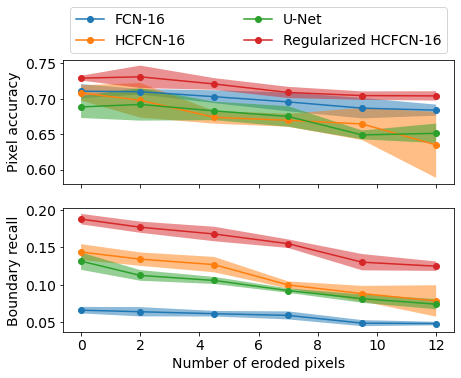

In [ ]:
#Plotting
model_list = [('FCN-16', 'FCN', 'cross_entropy'),
              ('HCFCN-16', 'HCFCN', 'cross_entropy'),
              ('U-Net', 'UNet', 'cross_entropy'),
              ('Regularized HCFCN-16', 'HCFCN', 'reg_cross_entropy_0.05_0')]

erode_list = [1, 5, 10, 15, 20, 25]

plot_coarseness(model_list, erode_list, 'suim', 'test')

### PanNuke dataset

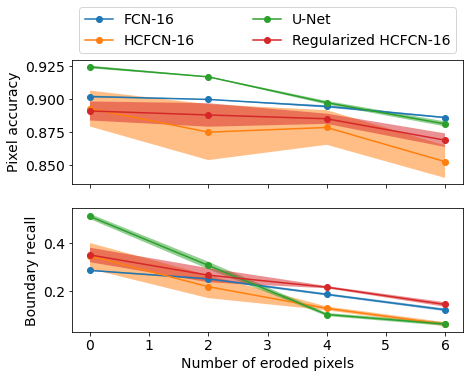

In [ ]:
#Plotting
model_list = [('FCN-16', 'FCN', 'cross_entropy'),
              ('HCFCN-16', 'HCFCN', 'cross_entropy'),
              ('U-Net', 'UNet', 'cross_entropy'),
              ('Regularized HCFCN-16', 'HCFCN', 'reg_cross_entropy_0.1_0')]

erode_list = [1, 5, 9, 13]

plot_coarseness(model_list, erode_list, 'pannuke', 'test', full_c=13)